In [15]:
import os
from pathlib import Path
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Obtener la ruta del directorio processed_constellations
processed_dir = Path('processed_constellations')

# Crear lista con todas las imágenes que terminan en _circles.png
circles_images = sorted([
    str(processed_dir / file) 
    for file in os.listdir(processed_dir) 
    if file.endswith('_circles.png')
])

print(f"Total de imágenes encontradas: {len(circles_images)}")
print("\nPrimeras 10 imágenes:")
for img in circles_images[:10]:
    print(f"  - {img}")

Total de imágenes encontradas: 88

Primeras 10 imágenes:
  - processed_constellations/image0_circles.png
  - processed_constellations/image10_circles.png
  - processed_constellations/image11_circles.png
  - processed_constellations/image12_circles.png
  - processed_constellations/image13_circles.png
  - processed_constellations/image14_circles.png
  - processed_constellations/image15_circles.png
  - processed_constellations/image16_circles.png
  - processed_constellations/image17_circles.png
  - processed_constellations/image18_circles.png


In [16]:
path = "./constelation_final_img.jpg"

# Leer la imagen
image = cv2.imread(path)
if image is None:
    raise FileNotFoundError(f"No se pudo cargar la imagen en la ruta: {path}")

In [17]:
def ransac_constellation(image_space, pattern_image):
    # Convertir a escala de grises
    gray_space = cv2.cvtColor(image_space, cv2.COLOR_BGR2GRAY)
    gray_pattern = cv2.cvtColor(pattern_image, cv2.COLOR_BGR2GRAY)

    # Detectar bordes usando Canny
    edges_space = cv2.Canny(gray_space, 50, 150)
    edges_pattern = cv2.Canny(gray_pattern, 50, 150)

    # Encontrar contornos
    contours_space, _ = cv2.findContours(edges_space, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_pattern, _ = cv2.findContours(edges_pattern, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Extraer puntos de los contornos
    points_space = np.vstack([cnt.squeeze() for cnt in contours_space if cnt.shape[0] >= 5])
    points_pattern = np.vstack([cnt.squeeze() for cnt in contours_pattern if cnt.shape[0] >= 5])

    if len(points_space) < 3 or len(points_pattern) < 3:
        raise ValueError("No hay suficientes puntos para aplicar RANSAC.")

    # Usar RANSAC para encontrar la mejor transformación
    model_robust, inliers = cv2.estimateAffinePartial2D(points_pattern, points_space, method=cv2.RANSAC)

    if model_robust is None:
        raise ValueError("No se pudo encontrar una transformación robusta.")

    # Aplicar la transformación a la imagen del patrón
    h, w = image_space.shape[:2]
    transformed_pattern = cv2.warpAffine(pattern_image, model_robust, (w, h))

    return transformed_pattern, model_robust

In [18]:
import pandas as pd

df = pd.read_csv('constellations_with_names.csv')

# Función para extraer el nombre del archivo sin extensión
def get_image_basename(full_path):
    return Path(full_path).stem

# Función para encontrar el path de la imagen procesada
def find_processed_image(basename):
    circles_path = processed_dir / f"{basename}_circles.png"
    if circles_path.exists():
        return str(circles_path)
    return None

# Función para calcular centroides de una imagen
def circles_centroides(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (9, 9), 2)
    circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=30,
                               param1=50, param2=30, minRadius=5, maxRadius=30)
    
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        centroids = [(x, y) for (x, y, r) in circles]
        return centroids
    else:
        return []

# Añadir columnas al DataFrame
df['image_basename'] = df['full_path'].apply(get_image_basename)
df['processed_image_path'] = df['image_basename'].apply(find_processed_image)

# Calcular centroides para cada imagen procesada
def get_centroids(processed_path):
    if processed_path and Path(processed_path).exists():
        img = cv2.imread(processed_path)
        if img is not None:
            return circles_centroides(img)
    return []

df['centroids'] = df['processed_image_path'].apply(get_centroids)
df['num_stars'] = df['centroids'].apply(len)

display(df.head())
print(f"\nTotal de constelaciones: {len(df)}")
print(f"Constelaciones con imágenes procesadas: {df['processed_image_path'].notna().sum()}")
print(f"Constelaciones con centroides detectados: {(df['num_stars'] > 0).sum()}")

full_path      constellation_name  \
0  /home/stargix/.cache/kagglehub/datasets/thepra...         Sagitta – Arrow   
1  /home/stargix/.cache/kagglehub/datasets/thepra...         Pisces – Fishes   
2  /home/stargix/.cache/kagglehub/datasets/thepra...        Lacerta – Lizard   
3  /home/stargix/.cache/kagglehub/datasets/thepra...  Chamaeleon – Chameleon   
4  /home/stargix/.cache/kagglehub/datasets/thepra...  Vulpecula – Little Fox   

  image_basename                          processed_image_path  \
0        image70  processed_constellations/image70_circles.png   
1        image65  processed_constellations/image65_circles.png   
2        image44  processed_constellations/image44_circles.png   
3        image21  processed_constellations/image21_circles.png   
4        image87  processed_constellations/image87_circles.png   

                                           centroids  num_stars  
0  [(855, 1030), (134, 232), (315, 421), (767, 75...          5  
1  [(465, 993), (951, 1048), (992, 1167), (164, 9...         15  
2  [(693, 981), (105, 196), (338, 393), (430, 556...          8  
3  [(1030, 471), (58, 703), (397, 488), (422, 707...          6  
4  [(783, 652), (40, 470), (286, 506), (448, 835)...          5


Total de constelaciones: 90
Constelaciones con imágenes procesadas: 88
Constelaciones con centroides detectados: 88


In [19]:
import sys
from pathlib import Path

# Agregar el directorio raíz al path
root_dir = Path().absolute().parent
sys.path.insert(0, str(root_dir))

# Agregar también el directorio python directamente al path
python_dir = root_dir / 'python'
sys.path.insert(0, str(python_dir))

# Ahora puedes importar directamente desde tools
from miquel.star_detection_tools import process_image, extract_properties_fast

print("Importación exitosa!")


Importación exitosa!


Cargando imagen: /home/stargix/Desktop/hackathons/NASA/NASA-AI-i-Oli/tests/constelation_final_img.jpg
Imagen cargada. Shape: (2860, 4021, 3)
Imagen redimensionada a: (1422, 2000, 3)

Objetos detectados: 50
Tipos detectados: {'star': 33, 'galaxy': 17}


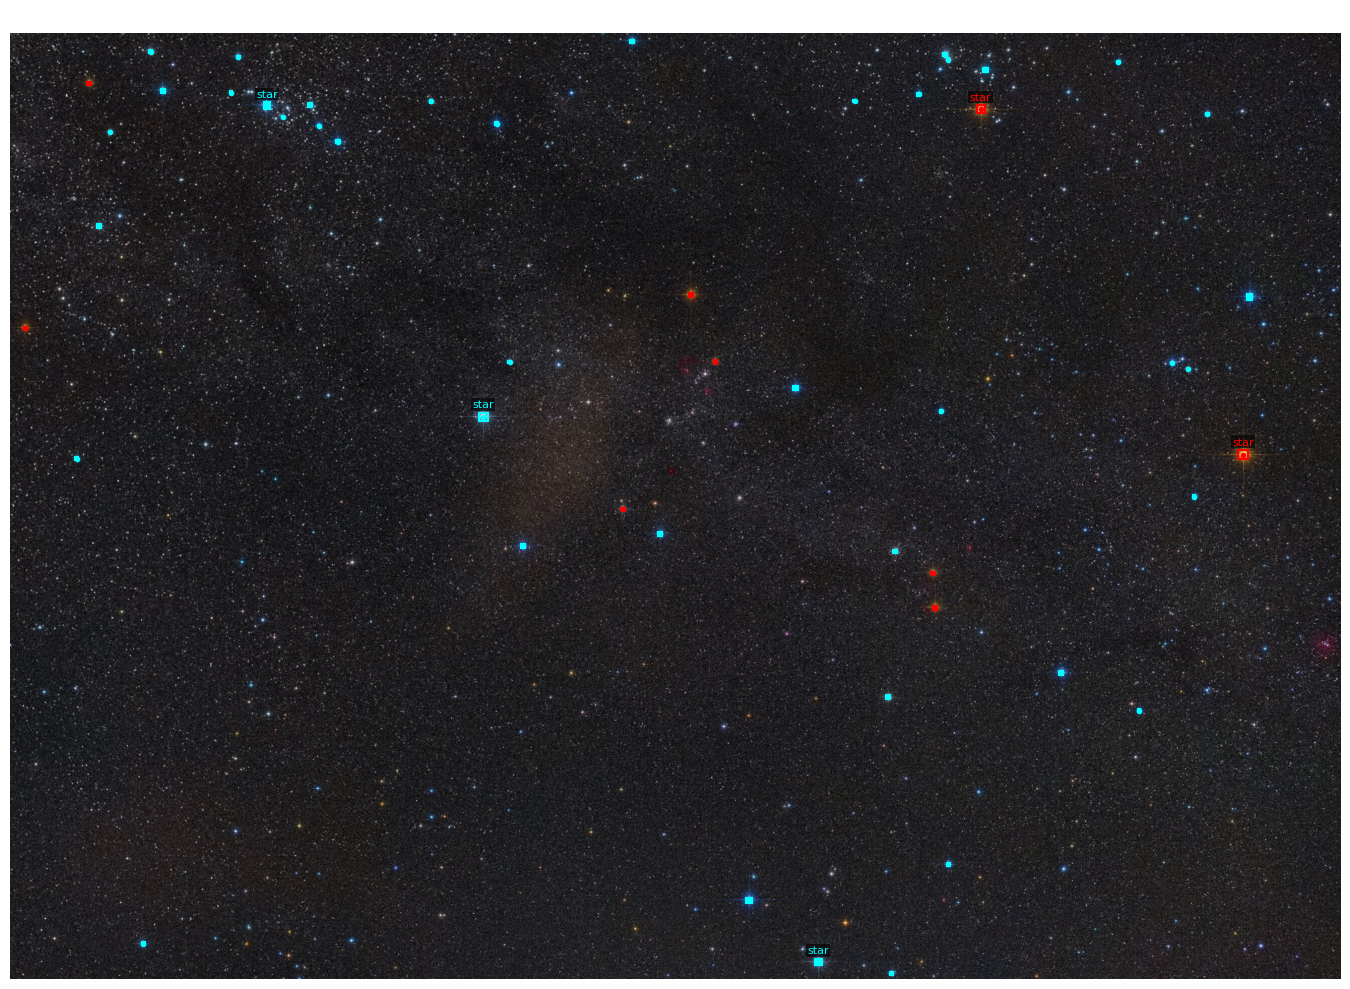

In [20]:
from PIL import Image
import numpy as np
from pathlib import Path

current_dir = Path().absolute()
path = str(current_dir / "constelation_final_img.jpg")

print(f"Cargando imagen: {path}")

# Cargar con PIL
pil_image = Image.open(path)
# Convertir a RGB si es necesario
if pil_image.mode != 'RGB':
    pil_image = pil_image.convert('RGB')

# Convertir PIL a numpy array (formato OpenCV)
image_np = np.array(pil_image)
# PIL usa RGB, OpenCV usa BGR, convertir para process_image
image_bgr = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

print(f"Imagen cargada. Shape: {image_bgr.shape}")

# Redimensionar si es muy grande para mejorar el rendimiento
resize_size = 2000
if max(image_bgr.shape[0], image_bgr.shape[1]) > resize_size:
    scale = resize_size / max(image_bgr.shape[0], image_bgr.shape[1])
    image_bgr = cv2.resize(image_bgr, (int(image_bgr.shape[1]*scale), int(image_bgr.shape[0]*scale)), interpolation=cv2.INTER_AREA)
    image_np = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    print(f"Imagen redimensionada a: {image_bgr.shape}")

# Process the image to extract large components
# Large_mask is a binary mask with only the large components
# Labels is an image where each pixel has the label of its component (0 is background)
# Stats is an array donde cada fila corresponde a un componente y tiene [x, y, width, height, area]
large_mask, labels, stats = process_image(image_bgr, automated=True, show_steps=False, max_components=50)

# Extract properties from detected components
stars_galaxies = extract_properties_fast(image_bgr, labels, stats, large_mask)

print(f"\nObjetos detectados: {len(stars_galaxies)}")

# Contar por tipo
from collections import Counter
types_count = Counter([obj['obj_type'] for obj in stars_galaxies])
print(f"Tipos detectados: {dict(types_count)}")

# Visualizar
fig, ax = plt.subplots(figsize=(14, 10))
ax.imshow(image_np)  # Usar la versión RGB para matplotlib

# Dibujar las bounding boxes y centroides
for obj in stars_galaxies:
    cx = obj['centroid_x']
    cy = obj['centroid_y']
    x = obj['bbox_x']
    y = obj['bbox_y']
    w = obj['bbox_width']
    h = obj['bbox_height']
    obj_type = obj['obj_type']
    color_str = obj['color']
    
    # Mapear colores de detección a colores de matplotlib
    color_map = {'red': 'red', 'blue': 'cyan', 'neutral': 'yellow'}
    edge_color = color_map.get(color_str, 'green')
    
    # Dibujar bounding box
    rect = plt.Rectangle((x, y), w, h, linewidth=1.5, edgecolor=edge_color, facecolor='none')
    ax.add_patch(rect)
    
    # Dibujar centroide
    ax.plot(cx, cy, 'o', color=edge_color, markersize=3)
    
    # Añadir etiqueta solo a objetos más grandes o interesantes
    if obj['area'] > 50:  # Umbral para mostrar etiquetas
        ax.text(cx, y - 5, obj_type, color=edge_color, fontsize=8, ha='center', va='bottom', 
                bbox=dict(facecolor='black', alpha=0.6, edgecolor='none', pad=1))

ax.set_title(f"Detección de Objetos Celestes ({len(stars_galaxies)} objetos)", fontsize=14, color='white')
plt.axis('off')
plt.tight_layout()
plt.show()


In [21]:
# Extraer los centroides de los objetos tipo 'galaxy' detectados en stars_galaxies
galaxy_centroids = [(obj['centroid_x'], obj['centroid_y']) for obj in stars_galaxies]

print(f"Total de galaxias detectadas: {len(galaxy_centroids)}")
print("Primeros 10 centroides de galaxias:")
for c in galaxy_centroids[:10]:
    print(c)

# Extraer los centroides de cada constelación desde el DataFrame
constellation_centroids = df['centroids'].tolist()

print(f"Total de constelaciones con centroides: {sum(len(c) > 0 for c in constellation_centroids)}")
print("Primeros 5 centroides de constelaciones:")
for centroids in constellation_centroids[:5]:
    print(centroids)

Total de galaxias detectadas: 50
Primeros 10 centroides de galaxias:
(935.0, 11.5)
(211.0, 27.0)
(1405.5, 31.5)
(343.0, 34.5)
(1410.0, 39.0)
(1666.0, 42.5)
(1466.0, 54.5)
(119.0, 74.5)
(229.5, 86.0)
(332.0, 88.5)
Total de constelaciones con centroides: 88
Primeros 5 centroides de constelaciones:
[(np.int64(855), np.int64(1030)), (np.int64(134), np.int64(232)), (np.int64(315), np.int64(421)), (np.int64(767), np.int64(757)), (np.int64(1009), np.int64(832))]
[(np.int64(465), np.int64(993)), (np.int64(951), np.int64(1048)), (np.int64(992), np.int64(1167)), (np.int64(164), np.int64(928)), (np.int64(866), np.int64(1094)), (np.int64(1046), np.int64(1126)), (np.int64(267), np.int64(701)), (np.int64(441), np.int64(511)), (np.int64(499), np.int64(111)), (np.int64(791), np.int64(1029)), (np.int64(313), np.int64(1039)), (np.int64(371), np.int64(205)), (np.int64(109), np.int64(1154)), (np.int64(446), np.int64(347)), (np.int64(601), np.int64(994))]
[(np.int64(693), np.int64(981)), (np.int64(105), np

In [22]:
def ransack(constellation_centroids, background_centroids, ransac_threshold=10.0, min_inliers=3, max_iters=2000, confidence=0.99, rotation_step=15):
    best_match = None
    best_inliers = 0
    best_model = None
    
    # Ensure inputs are numpy arrays with correct dtype
    constellation_centroids = np.array(constellation_centroids, dtype=np.float32)
    background_centroids = np.array(background_centroids, dtype=np.float32)

    for angle in range(0, 360, rotation_step):
        theta = np.radians(angle)
        rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                                     [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
        
        rotated_pattern = np.dot(constellation_centroids, rotation_matrix.T)

        if len(rotated_pattern) < 3 or len(background_centroids) < 3:
            continue

        # Source (pattern) first, destination (background) second
        model_robust, inliers = cv2.estimateAffinePartial2D(
            rotated_pattern,       # Source: constellation pattern
            background_centroids,  # Destination: space image
            method=cv2.RANSAC, 
            ransacReprojThreshold=ransac_threshold, 
            maxIters=max_iters, 
            confidence=confidence
        )

        if model_robust is not None and inliers is not None:
            num_inliers = np.sum(inliers)
            if num_inliers > best_inliers and num_inliers >= min_inliers:
                best_inliers = num_inliers
                best_model = model_robust
                best_match = {
                    'rotation_angle': angle,
                    'inliers_ratio': num_inliers / len(constellation_centroids),
                    'inliers_count': num_inliers,
                    'transformation_matrix': model_robust
                }

    return best_match

In [28]:
def ransack(constellation_centroids, background_centroids, 
                                 ransac_threshold=10.0, min_inliers=3, 
                                 max_iters=2000, confidence=0.99, 
                                 rotation_step=15, scale_range=(0.5, 2.0), scale_steps=5):
    """
    RANSAC con exploración explícita de rotaciones Y escalas
    
    Args:
        scale_range: tuple (min_scale, max_scale) para probar diferentes tamaños
        scale_steps: número de escalas a probar en el rango
    """
    best_match = None
    best_inliers = 0
    best_model = None
    
    constellation_centroids = np.array(constellation_centroids, dtype=np.float32)
    background_centroids = np.array(background_centroids, dtype=np.float32)
    
    if len(constellation_centroids) < 3 or len(background_centroids) < 3:
        return None
    
    # Generar las escalas a probar
    scales_to_test = np.linspace(scale_range[0], scale_range[1], scale_steps)
    
    total_iterations = len(scales_to_test) * (360 // rotation_step)
    iteration = 0
    
    print(f"  Probando {len(scales_to_test)} escalas × {360//rotation_step} rotaciones = {total_iterations} combinaciones")
    
    # Iterar sobre diferentes escalas
    for scale in scales_to_test:
        # Escalar el patrón
        scaled_pattern = constellation_centroids * scale
        
        # Iterar sobre diferentes rotaciones
        for angle in range(0, 360, rotation_step):
            iteration += 1
            if iteration % 50 == 0:
                print(f"    Progreso: {iteration}/{total_iterations} ({iteration*100//total_iterations}%)")
            
            theta = np.radians(angle)
            rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                                         [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
            
            # Rotar el patrón escalado
            transformed_pattern = np.dot(scaled_pattern, rotation_matrix.T).astype(np.float32)
            
            # Encontrar correspondencias usando nearest neighbor
            distances = cdist(transformed_pattern, background_centroids)
            matches_indices = np.argmin(distances, axis=1)
            matches_distances = np.min(distances, axis=1)
            
            # Filtrar matches que están demasiado lejos
            valid_matches = matches_distances < ransac_threshold
            
            if np.sum(valid_matches) < min_inliers:
                continue
            
            # Crear pares de puntos correspondientes
            src_points = transformed_pattern[valid_matches]
            dst_points = background_centroids[matches_indices[valid_matches]]
            
            if len(src_points) < 3:
                continue
            
            try:
                # Usar RANSAC para refinar la transformación
                model_robust, inliers = cv2.estimateAffinePartial2D(
                    src_points,
                    dst_points,
                    method=cv2.RANSAC,
                    ransacReprojThreshold=ransac_threshold,
                    maxIters=max_iters,
                    confidence=confidence
                )

                if model_robust is not None and inliers is not None:
                    num_inliers = np.sum(inliers)
                    if num_inliers > best_inliers and num_inliers >= min_inliers:
                        best_inliers = num_inliers
                        best_model = model_robust
                        
                        # Extraer la escala final de la matriz de transformación
                        # Para matriz afín parcial: [[a, -b, tx], [b, a, ty]]
                        # Escala = sqrt(a^2 + b^2)
                        a, b = model_robust[0, 0], model_robust[1, 0]
                        final_scale = np.sqrt(a**2 + b**2)
                        
                        best_match = {
                            'rotation_angle': angle,
                            'tested_scale': float(scale),  # Escala que probamos explícitamente
                            'final_scale': float(final_scale),  # Escala final después de RANSAC
                            'inliers_ratio': num_inliers / len(constellation_centroids),
                            'inliers_count': int(num_inliers),
                            'transformation_matrix': model_robust,
                            'matched_indices': matches_indices[valid_matches][inliers.flatten().astype(bool)]
                        }
            except cv2.error:
                continue

    return best_match

In [29]:
def find_from_all_constellations(space_centroids, all_constellation_centroids, ransac_threshold=10.0, min_inliers=3, max_iters=2000, confidence=0.99, rotation_step=15):
    matches = []
    for idx, pattern_centroids in enumerate(all_constellation_centroids):
        if len(pattern_centroids) < 3:
            continue  # Necesitamos al menos 3 puntos para RANSAC
        match = ransack(space_centroids, np.array(pattern_centroids), ransac_threshold, min_inliers, max_iters, confidence, rotation_step)
        if match:
            match['constellation_index'] = idx
            matches.append(match)
    return matches

In [24]:
space_centroids = np.array(galaxy_centroids, dtype=np.float32)
all_constellation_centroids = constellation_centroids

matches = find_from_all_constellations(
    all_constellation_centroids, 
    space_centroids,
    ransac_threshold=100.0,  # Más permisivo
    min_inliers=2,           # Mínimo 2 inliers
    rotation_step=360         # Menos rotaciones para probar más rápido
)

matches

[]

In [ ]:
from scipy.spatial.distance import cdist

def ransack(constellation_centroids, background_centroids, ransac_threshold=10.0, min_inliers=3, max_iters=2000, confidence=0.99, rotation_step=15):
    best_match = None
    best_inliers = 0
    best_model = None
    
    constellation_centroids = np.array(constellation_centroids, dtype=np.float32)
    background_centroids = np.array(background_centroids, dtype=np.float32)
    
    if len(constellation_centroids) < 3 or len(background_centroids) < 3:
        return None

    for angle in range(0, 360, rotation_step):
        theta = np.radians(angle)
        rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                                     [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
        
        rotated_pattern = np.dot(constellation_centroids, rotation_matrix.T).astype(np.float32)
        
        # Encontrar correspondencias usando nearest neighbor
        # Para cada punto del patrón rotado, encontrar el punto más cercano en background
        distances = cdist(rotated_pattern, background_centroids)
        matches_indices = np.argmin(distances, axis=1)
        matches_distances = np.min(distances, axis=1)
        
        # Filtrar matches que están demasiado lejos
        valid_matches = matches_distances < ransac_threshold
        
        if np.sum(valid_matches) < min_inliers:
            continue
        
        # Crear pares de puntos correspondientes
        src_points = rotated_pattern[valid_matches]
        dst_points = background_centroids[matches_indices[valid_matches]]
        
        if len(src_points) < 3:
            continue
        
        try:
            # Ahora sí podemos usar estimateAffinePartial2D con correspondencias 1:1
            model_robust, inliers = cv2.estimateAffinePartial2D(
                src_points,
                dst_points,
                method=cv2.RANSAC,
                ransacReprojThreshold=ransac_threshold,
                maxIters=max_iters,
                confidence=confidence
            )

            if model_robust is not None and inliers is not None:
                num_inliers = np.sum(inliers)
                if num_inliers > best_inliers and num_inliers >= min_inliers:
                    best_inliers = num_inliers
                    best_model = model_robust
                    best_match = {
                        'rotation_angle': angle,
                        'inliers_ratio': num_inliers / len(constellation_centroids),
                        'inliers_count': int(num_inliers),
                        'transformation_matrix': model_robust,
                        'matched_indices': matches_indices[valid_matches][inliers.flatten().astype(bool)]
                    }
        except cv2.error as e:
            continue

    return best_match


def find_from_all_constellations(space_centroids, all_constellation_centroids, ransac_threshold=10.0, min_inliers=3, max_iters=2000, confidence=0.99, rotation_step=15):
    matches = []
    
    space_centroids = np.array(space_centroids, dtype=np.float32)
    
    print(f"Buscando matches en {len(all_constellation_centroids)} constelaciones")
    print(f"Space tiene {len(space_centroids)} centroides")
    print(f"Umbral RANSAC: {ransac_threshold}, Min inliers: {min_inliers}")
    
    for idx, pattern_centroids in enumerate(all_constellation_centroids):
        pattern_centroids = np.array(pattern_centroids, dtype=np.float32)
        
        if len(pattern_centroids) < 3:
            continue
        
        print(f"Procesando constelación {idx} con {len(pattern_centroids)} puntos...")
        match = ransack(pattern_centroids, space_centroids, ransac_threshold, min_inliers, max_iters, confidence, rotation_step)
        
        if match:
            match['constellation_index'] = idx
            matches.append(match)
            print(f"  ✓ Match encontrado! {match['inliers_count']} inliers, ángulo: {match['rotation_angle']}°")
    
    return matches

# Ejecución con parámetros más permisivos para empezar
space_centroids = np.array(galaxy_centroids, dtype=np.float32)
all_constellation_centroids = constellation_centroids

print(f"galaxy_centroids shape: {space_centroids.shape}")
print(f"Número de constelaciones: {len(all_constellation_centroids)}")

matches = find_from_all_constellations(
    space_centroids,
    all_constellation_centroids,
    ransac_threshold=50.0,  # Distancia máxima para considerar match
    min_inliers=3,           # Al menos 3 puntos deben coincidir
    rotation_step=15,        # Probar cada 15 grados
    max_iters=1000
)

print(f"\n{'='*50}")
print(f"Encontrados {len(matches)} matches")
print(f"{'='*50}")

# Mostrar detalles de los matches
for match in matches:
    print(f"\nConstelación {match['constellation_index']}:")
    print(f"  - Inliers: {match['inliers_count']}")
    print(f"  - Ratio: {match['inliers_ratio']:.2%}")
    print(f"  - Ángulo: {match['rotation_angle']}°")

print(len(matches))

galaxy_centroids shape: (50, 2)
Número de constelaciones: 90
Buscando matches en 90 constelaciones
Space tiene 50 centroides
Umbral RANSAC: 50.0, Min inliers: 3
Procesando constelación 0 con 5 puntos...
  Probando 5 escalas × 24 rotaciones = 120 combinaciones
    Progreso: 50/120 (41%)
    Progreso: 100/120 (83%)
  ✓ Match encontrado! 4 inliers, ángulo: 330°
Procesando constelación 1 con 15 puntos...
  Probando 5 escalas × 24 rotaciones = 120 combinaciones
    Progreso: 50/120 (41%)
    Progreso: 100/120 (83%)
  ✓ Match encontrado! 3 inliers, ángulo: 15°
Procesando constelación 2 con 8 puntos...
  Probando 5 escalas × 24 rotaciones = 120 combinaciones
    Progreso: 50/120 (41%)
    Progreso: 100/120 (83%)
  ✓ Match encontrado! 4 inliers, ángulo: 315°
Procesando constelación 3 con 6 puntos...
  Probando 5 escalas × 24 rotaciones = 120 combinaciones
    Progreso: 50/120 (41%)
    Progreso: 100/120 (83%)
Procesando constelación 4 con 5 puntos...
  Probando 5 escalas × 24 rotaciones = 120 

In [32]:
from scipy.spatial.distance import cdist

def ransack_with_explicit_scale(constellation_centroids, background_centroids, 
                                 ransac_threshold=10.0, min_inliers=3, 
                                 max_iters=2000, confidence=0.99, 
                                 rotation_step=15, scale_range=(0.5, 2.0), scale_steps=5):
    """
    RANSAC con exploración explícita de rotaciones Y escalas
    
    Args:
        scale_range: tuple (min_scale, max_scale) para probar diferentes tamaños
        scale_steps: número de escalas a probar en el rango
    """
    best_match = None
    best_inliers = 0
    best_model = None
    
    constellation_centroids = np.array(constellation_centroids, dtype=np.float32)
    background_centroids = np.array(background_centroids, dtype=np.float32)
    
    if len(constellation_centroids) < 3 or len(background_centroids) < 3:
        return None
    
    # Generar las escalas a probar
    scales_to_test = np.linspace(scale_range[0], scale_range[1], scale_steps)
    
    total_iterations = len(scales_to_test) * (360 // rotation_step)
    iteration = 0
    
    print(f"  Probando {len(scales_to_test)} escalas × {360//rotation_step} rotaciones = {total_iterations} combinaciones")
    
    # Iterar sobre diferentes escalas
    for scale in scales_to_test:
        # Escalar el patrón
        scaled_pattern = constellation_centroids * scale
        
        # Iterar sobre diferentes rotaciones
        for angle in range(0, 360, rotation_step):
            iteration += 1
            if iteration % 50 == 0:
                print(f"    Progreso: {iteration}/{total_iterations} ({iteration*100//total_iterations}%)")
            
            theta = np.radians(angle)
            rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                                         [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
            
            # Rotar el patrón escalado
            transformed_pattern = np.dot(scaled_pattern, rotation_matrix.T).astype(np.float32)
            
            # Encontrar correspondencias usando nearest neighbor
            distances = cdist(transformed_pattern, background_centroids)
            matches_indices = np.argmin(distances, axis=1)
            matches_distances = np.min(distances, axis=1)
            
            # Filtrar matches que están demasiado lejos
            valid_matches = matches_distances < ransac_threshold
            
            if np.sum(valid_matches) < min_inliers:
                continue
            
            # Crear pares de puntos correspondientes
            src_points = transformed_pattern[valid_matches]
            dst_points = background_centroids[matches_indices[valid_matches]]
            
            if len(src_points) < 3:
                continue
            
            try:
                # Usar RANSAC para refinar la transformación
                model_robust, inliers = cv2.estimateAffinePartial2D(
                    src_points,
                    dst_points,
                    method=cv2.RANSAC,
                    ransacReprojThreshold=ransac_threshold,
                    maxIters=max_iters,
                    confidence=confidence
                )

                if model_robust is not None and inliers is not None:
                    num_inliers = np.sum(inliers)
                    if num_inliers > best_inliers and num_inliers >= min_inliers:
                        best_inliers = num_inliers
                        best_model = model_robust
                        
                        # Extraer la escala final de la matriz de transformación
                        # Para matriz afín parcial: [[a, -b, tx], [b, a, ty]]
                        # Escala = sqrt(a^2 + b^2)
                        a, b = model_robust[0, 0], model_robust[1, 0]
                        final_scale = np.sqrt(a**2 + b**2)
                        
                        best_match = {
                            'rotation_angle': angle,
                            'tested_scale': float(scale),  # Escala que probamos explícitamente
                            'final_scale': float(final_scale),  # Escala final después de RANSAC
                            'inliers_ratio': num_inliers / len(constellation_centroids),
                            'inliers_count': int(num_inliers),
                            'transformation_matrix': model_robust,
                            'matched_indices': matches_indices[valid_matches][inliers.flatten().astype(bool)]
                        }
            except cv2.error:
                continue

    return best_match


def find_from_all_constellations_with_scale(space_centroids, all_constellation_centroids, 
                                            ransac_threshold=10.0, min_inliers=3, 
                                            max_iters=2000, confidence=0.99, 
                                            rotation_step=15, scale_range=(0.5, 2.0), scale_steps=5):
    """
    Buscar todas las constelaciones con exploración explícita de escalas
    """
    matches = []
    
    space_centroids = np.array(space_centroids, dtype=np.float32)
    
    print(f"Buscando matches en {len(all_constellation_centroids)} constelaciones")
    print(f"Space tiene {len(space_centroids)} centroides")
    print(f"Parámetros: threshold={ransac_threshold}, min_inliers={min_inliers}")
    print(f"Escalas: {scale_range[0]} a {scale_range[1]} en {scale_steps} pasos")
    print(f"Rotaciones: cada {rotation_step}°")
    
    for idx, pattern_centroids in enumerate(all_constellation_centroids):
        pattern_centroids = np.array(pattern_centroids, dtype=np.float32)
        
        if len(pattern_centroids) < 3:
            continue
        
        print(f"\n[{idx+1}/{len(all_constellation_centroids)}] Procesando constelación {idx} ({len(pattern_centroids)} puntos)...")
        
        match = ransack_with_explicit_scale(
            pattern_centroids, 
            space_centroids, 
            ransac_threshold, 
            min_inliers, 
            max_iters, 
            confidence, 
            rotation_step,
            scale_range,
            scale_steps
        )
        
        if match:
            match['constellation_index'] = idx
            matches.append(match)
            print(f"  ✓✓✓ MATCH ENCONTRADO!")
            print(f"      Inliers: {match['inliers_count']}")
            print(f"      Escala probada: {match['tested_scale']:.2f}x")
            print(f"      Escala final: {match['final_scale']:.2f}x")
            print(f"      Ángulo: {match['rotation_angle']}°")
    
    return matches


# Ejecutar con diferentes configuraciones de escala
space_centroids = np.array(galaxy_centroids, dtype=np.float32)
all_constellation_centroids = constellation_centroids

print(f"galaxy_centroids shape: {space_centroids.shape}")
print(f"Número de constelaciones: {len(all_constellation_centroids)}")
print("\n" + "="*70)

matches = find_from_all_constellations_with_scale(
    space_centroids,
    all_constellation_centroids,
    ransac_threshold=50.0,      # Distancia máxima para considerar match
    min_inliers=3,               # Al menos 3 puntos deben coincidir
    rotation_step=30,            # Probar cada 30 grados (más rápido)
    scale_range=(0.3, 3.0),      # Probar desde 30% hasta 300% del tamaño original
    scale_steps=8,               # 8 escalas diferentes
    max_iters=1000
)

print(f"\n{'='*70}")
print(f"RESULTADO FINAL: Encontrados {len(matches)} matches")
print(f"{'='*70}")

# Mostrar detalles de los matches ordenados por ratio de inliers
if matches:
    matches_sorted = sorted(matches, key=lambda x: x['inliers_ratio'], reverse=True)
    
    for i, match in enumerate(matches_sorted[:10], 1):  # Top 10
        const_name = df.iloc[match['constellation_index']]['constellation_name']
        print(f"\n{i}. {const_name}")
        print(f"   Índice: {match['constellation_index']}")
        print(f"   Inliers: {match['inliers_count']} ({match['inliers_ratio']:.1%})")
        print(f"   Escala probada: {match['tested_scale']:.2f}x")
        print(f"   Escala final (RANSAC): {match['final_scale']:.2f}x")
        print(f"   Ángulo: {match['rotation_angle']}°")
else:
    print("\n❌ No se encontraron matches")

galaxy_centroids shape: (50, 2)
Número de constelaciones: 90

Buscando matches en 90 constelaciones
Space tiene 50 centroides
Parámetros: threshold=50.0, min_inliers=3
Escalas: 0.3 a 3.0 en 8 pasos
Rotaciones: cada 30°

[1/90] Procesando constelación 0 (5 puntos)...
  Probando 8 escalas × 12 rotaciones = 96 combinaciones
    Progreso: 50/96 (52%)
  ✓✓✓ MATCH ENCONTRADO!
      Inliers: 3
      Escala probada: 0.30x
      Escala final: 1.11x
      Ángulo: 330°

[2/90] Procesando constelación 1 (15 puntos)...
  Probando 8 escalas × 12 rotaciones = 96 combinaciones
    Progreso: 50/96 (52%)
  ✓✓✓ MATCH ENCONTRADO!
      Inliers: 7
      Escala probada: 0.30x
      Escala final: 0.89x
      Ángulo: 330°

[3/90] Procesando constelación 2 (8 puntos)...
  Probando 8 escalas × 12 rotaciones = 96 combinaciones
    Progreso: 50/96 (52%)
  ✓✓✓ MATCH ENCONTRADO!
      Inliers: 6
      Escala probada: 0.30x
      Escala final: 1.01x
      Ángulo: 330°

[4/90] Procesando constelación 3 (6 puntos)...


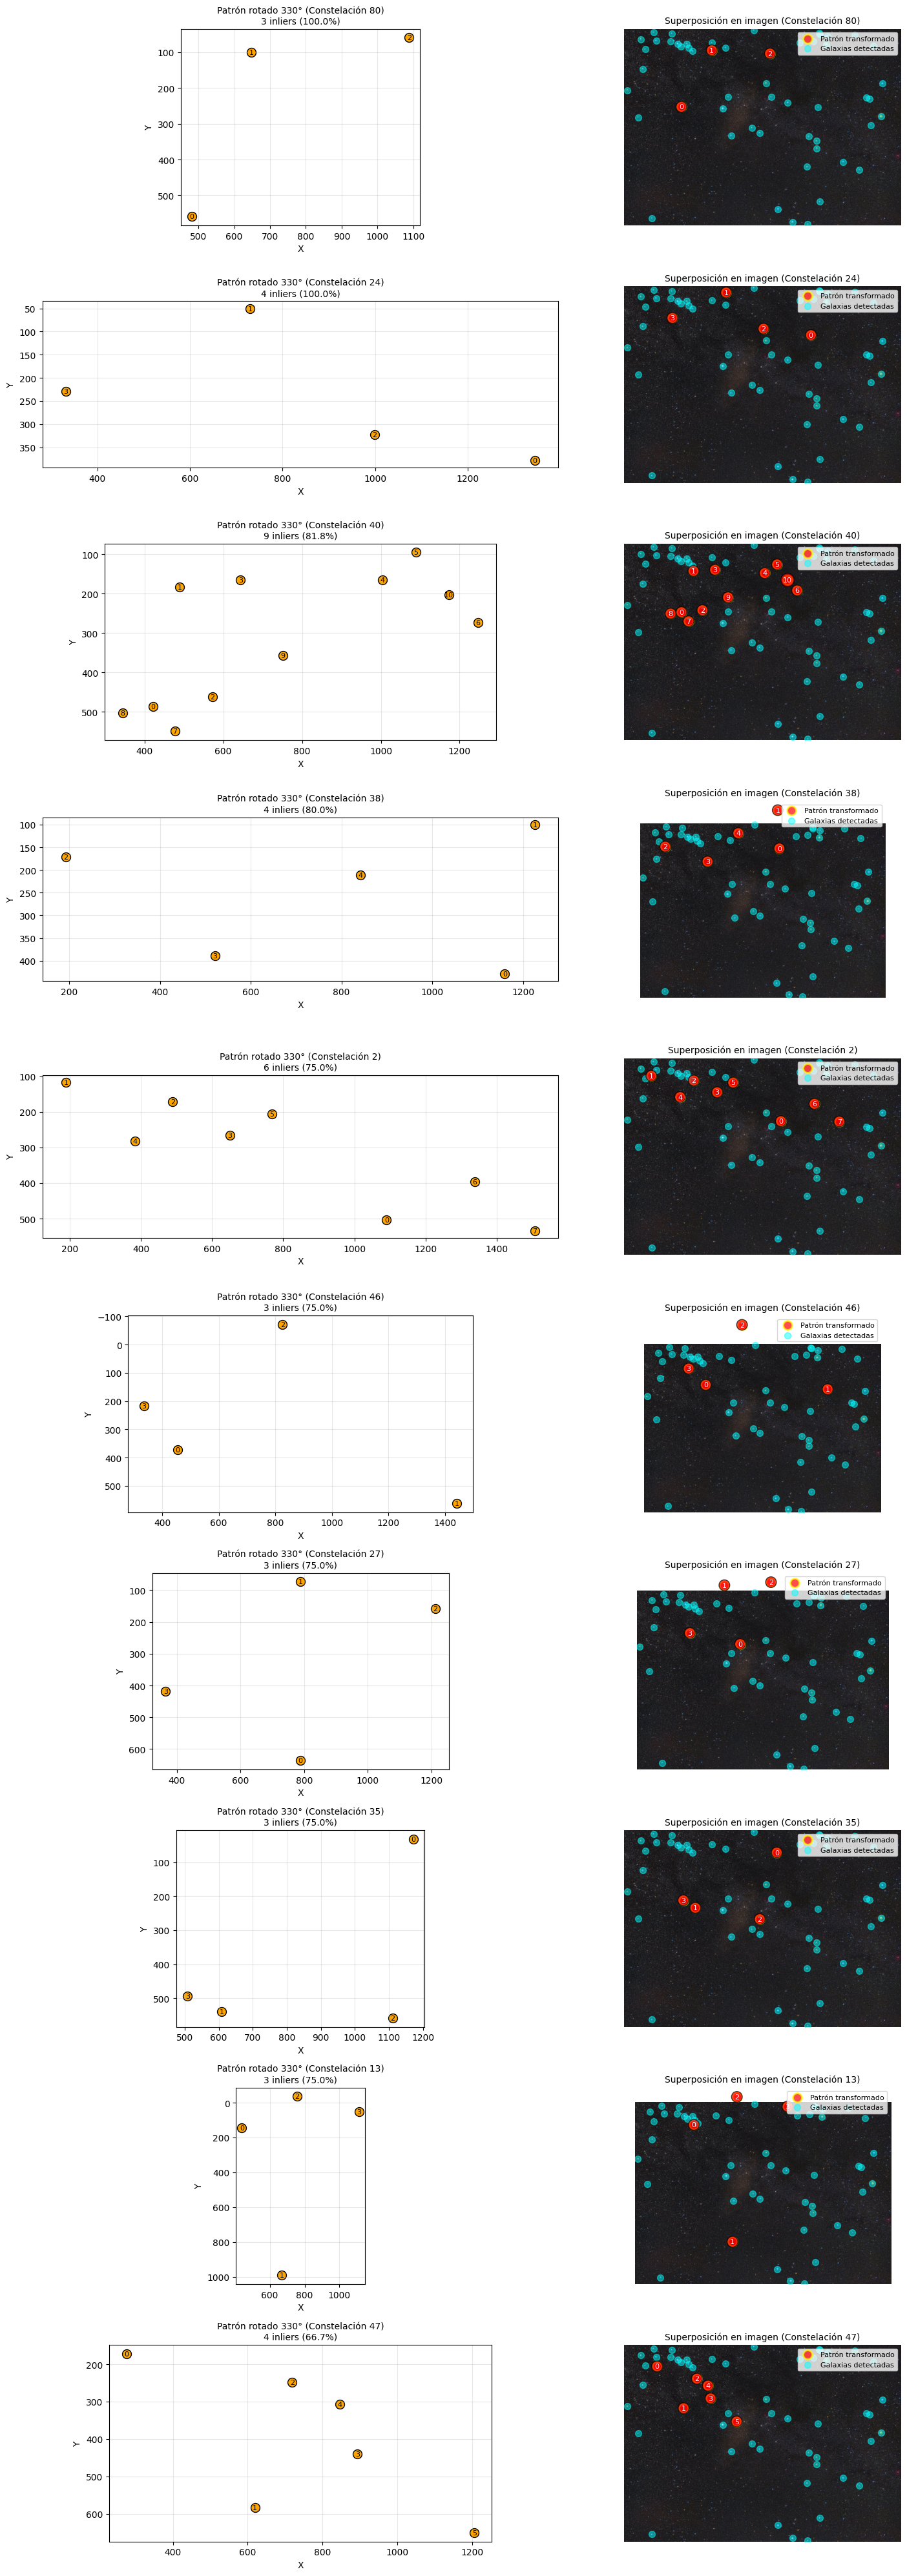


Detalles de los matches:

1. Leo Minor – Little Lion
   Índice: 80
   Inliers: 3/3 (100.0%)
   Ángulo de rotación: 330°
   Matriz de transformación:
   [[  0.94012972  -0.13756321  36.25735918]
 [  0.13756321   0.94012972 -28.22623526]]

2. Caelum – Chisel
   Índice: 24
   Inliers: 4/4 (100.0%)
   Ángulo de rotación: 330°
   Matriz de transformación:
   [[ 0.98437746  0.02353933 14.7173339 ]
 [-0.02353933  0.98437746 12.49153585]]

3. Aries – Ram
   Índice: 40
   Inliers: 9/11 (81.8%)
   Ángulo de rotación: 330°
   Matriz de transformación:
   [[  0.99630056  -0.06763914  24.22819064]
 [  0.06763914   0.99630056 -18.38216902]]

4. Cassiopeia – Vain Queen
   Índice: 38
   Inliers: 4/5 (80.0%)
   Ángulo de rotación: 330°
   Matriz de transformación:
   [[ 0.90463968  0.22509541 -9.64869172]
 [-0.22509541  0.90463968 75.94192204]]

5. Lacerta – Lizard
   Índice: 2
   Inliers: 6/8 (75.0%)
   Ángulo de rotación: 330°
   Matriz de transformación:
   [[ 1.00815317  0.06800209 -3.53250003]
 [

In [33]:
# Convertir matches a DataFrame y ordenar
import pandas as pd

if len(matches) == 0:
    print("No hay matches para visualizar")
else:
    matches_df = pd.DataFrame(matches)
    top_matches = matches_df.sort_values('inliers_ratio', ascending=False).head(10)
    
    n_matches = len(top_matches)
    fig, axes = plt.subplots(n_matches, 2, figsize=(16, 4*n_matches))
    
    # Si solo hay un match, axes no será un array 2D
    if n_matches == 1:
        axes = axes.reshape(1, -1)
    
    for idx, (match_idx, row) in enumerate(top_matches.iterrows()):
        # Obtener datos del match
        const_idx = row['constellation_index']
        pattern_centroids = np.array(constellation_centroids[const_idx], dtype=np.float32)
        matrix = row['transformation_matrix']
        angle = row['rotation_angle']
        
        # Rotar el patrón con el ángulo encontrado
        theta = np.radians(angle)
        rot_mat = np.array([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
        rotated_pattern = np.dot(pattern_centroids, rot_mat.T)
        
        # Panel izquierdo: Patrón rotado (sin transformación afín)
        axes[idx, 0].scatter(rotated_pattern[:, 0], rotated_pattern[:, 1], c='orange', s=100, edgecolors='black', linewidths=1)
        # Conectar puntos para ver la forma
        for i in range(len(rotated_pattern)):
            axes[idx, 0].text(rotated_pattern[i, 0], rotated_pattern[i, 1], str(i), 
                             fontsize=8, ha='center', va='center')
        
        axes[idx, 0].set_title(f'Patrón rotado {angle}° (Constelación {const_idx})\n{row["inliers_count"]} inliers ({row["inliers_ratio"]:.1%})', 
                               fontsize=10)
        axes[idx, 0].set_aspect('equal')
        axes[idx, 0].invert_yaxis()  # Invertir Y para que coincida con coordenadas de imagen
        axes[idx, 0].grid(True, alpha=0.3)
        axes[idx, 0].set_xlabel('X')
        axes[idx, 0].set_ylabel('Y')
        
        # Panel derecho: Transformación completa sobre la imagen
        # Aplicar la matriz de transformación afín completa
        ones = np.ones((len(rotated_pattern), 1))
        rotated_homogeneous = np.hstack([rotated_pattern, ones])
        transformed = rotated_homogeneous @ matrix.T
        
        axes[idx, 1].imshow(image_np)
        axes[idx, 1].scatter(transformed[:, 0], transformed[:, 1], c='red', s=100, 
                            edgecolors='yellow', linewidths=2, alpha=0.7, label='Patrón transformado')
        axes[idx, 1].scatter(space_centroids[:, 0], space_centroids[:, 1], c='cyan', s=50, 
                            alpha=0.5, label='Galaxias detectadas')
        
        # Numerar puntos transformados
        for i in range(len(transformed)):
            axes[idx, 1].text(transformed[i, 0], transformed[i, 1], str(i), 
                             color='white', fontsize=8, ha='center', va='center',
                             bbox=dict(boxstyle='circle', facecolor='red', alpha=0.7))
        
        axes[idx, 1].set_title(f'Superposición en imagen (Constelación {const_idx})', fontsize=10)
        axes[idx, 1].legend(loc='upper right', fontsize=8)
        axes[idx, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Mostrar información detallada
    print("\nDetalles de los matches:")
    print("="*70)
    for idx, (match_idx, row) in enumerate(top_matches.iterrows()):
        const_idx = row['constellation_index']
        const_name = df.iloc[const_idx]['constellation_name'] if 'constellation_name' in df.columns else f"Constelación {const_idx}"
        print(f"\n{idx+1}. {const_name}")
        print(f"   Índice: {const_idx}")
        print(f"   Inliers: {row['inliers_count']}/{len(constellation_centroids[const_idx])} ({row['inliers_ratio']:.1%})")
        print(f"   Ángulo de rotación: {row['rotation_angle']}°")
        print(f"   Matriz de transformación:")
        print(f"   {row['transformation_matrix']}")

Nombres de constelaciones disponibles:
['Sagitta – Arrow' 'Pisces – Fishes' 'Lacerta – Lizard'
 'Chamaeleon – Chameleon' 'Vulpecula – Little Fox' 'Draco – Dragon'
 'Orion – Hunter' 'Norma – Level' 'Sagittarius – Archer' 'Octans – Octant'
 'Equuleus – Little Horse' 'Lynx – Lynx' 'Pictor – Painter’s Easel'
 'Microscopium – Microscope' 'Serpens – Serpent' 'Antlia – Air Pump'
 'Tucana – Toucan' 'Hydrus – Watersnake' 'Monoceros – Unicorn'
 'Eridanus – River']

✓ Encontrado 'Gemini':
  - Índice 70: Gemini – Twins

✓ Encontrado 'Taurus':
  - Índice 64: Centaurus – Centaur
  - Índice 79: Taurus – Bull

✓ Encontrado 'Auriga':
  - Índice 85: Auriga – Charioteer

Índices totales encontrados: [64, 85, 70, 79]

✓ Encontrados 4 matches para las constelaciones buscadas



rotation_angle  tested_scale  final_scale  inliers_ratio  inliers_count  \
49             330           0.3     0.996055       0.458333             11   
55             330           0.3     0.902629       0.529412              9   
62             330           0.3     0.932960       0.571429              8   
67             300           0.3     0.956115       0.363636              4   

                                transformation_matrix  \
49  [[0.99540421837348, -0.03599953686434919, 6.23...   
55  [[0.9005363914889616, -0.06143396521582506, 37...   
62  [[0.9329169081491133, -0.008934271784269927, 2...   
67  [[0.956101780862951, -0.005098663665810216, -6...   

                         matched_indices  constellation_index  
49  [1, 7, 9, 1, 13, 7, 8, 9, 19, 7, 13]                   64  
55       [9, 7, 1, 13, 13, 7, 13, 7, 13]                   70  
62           [17, 8, 13, 8, 8, 8, 1, 19]                   79  
67                          [3, 8, 7, 1]                   85

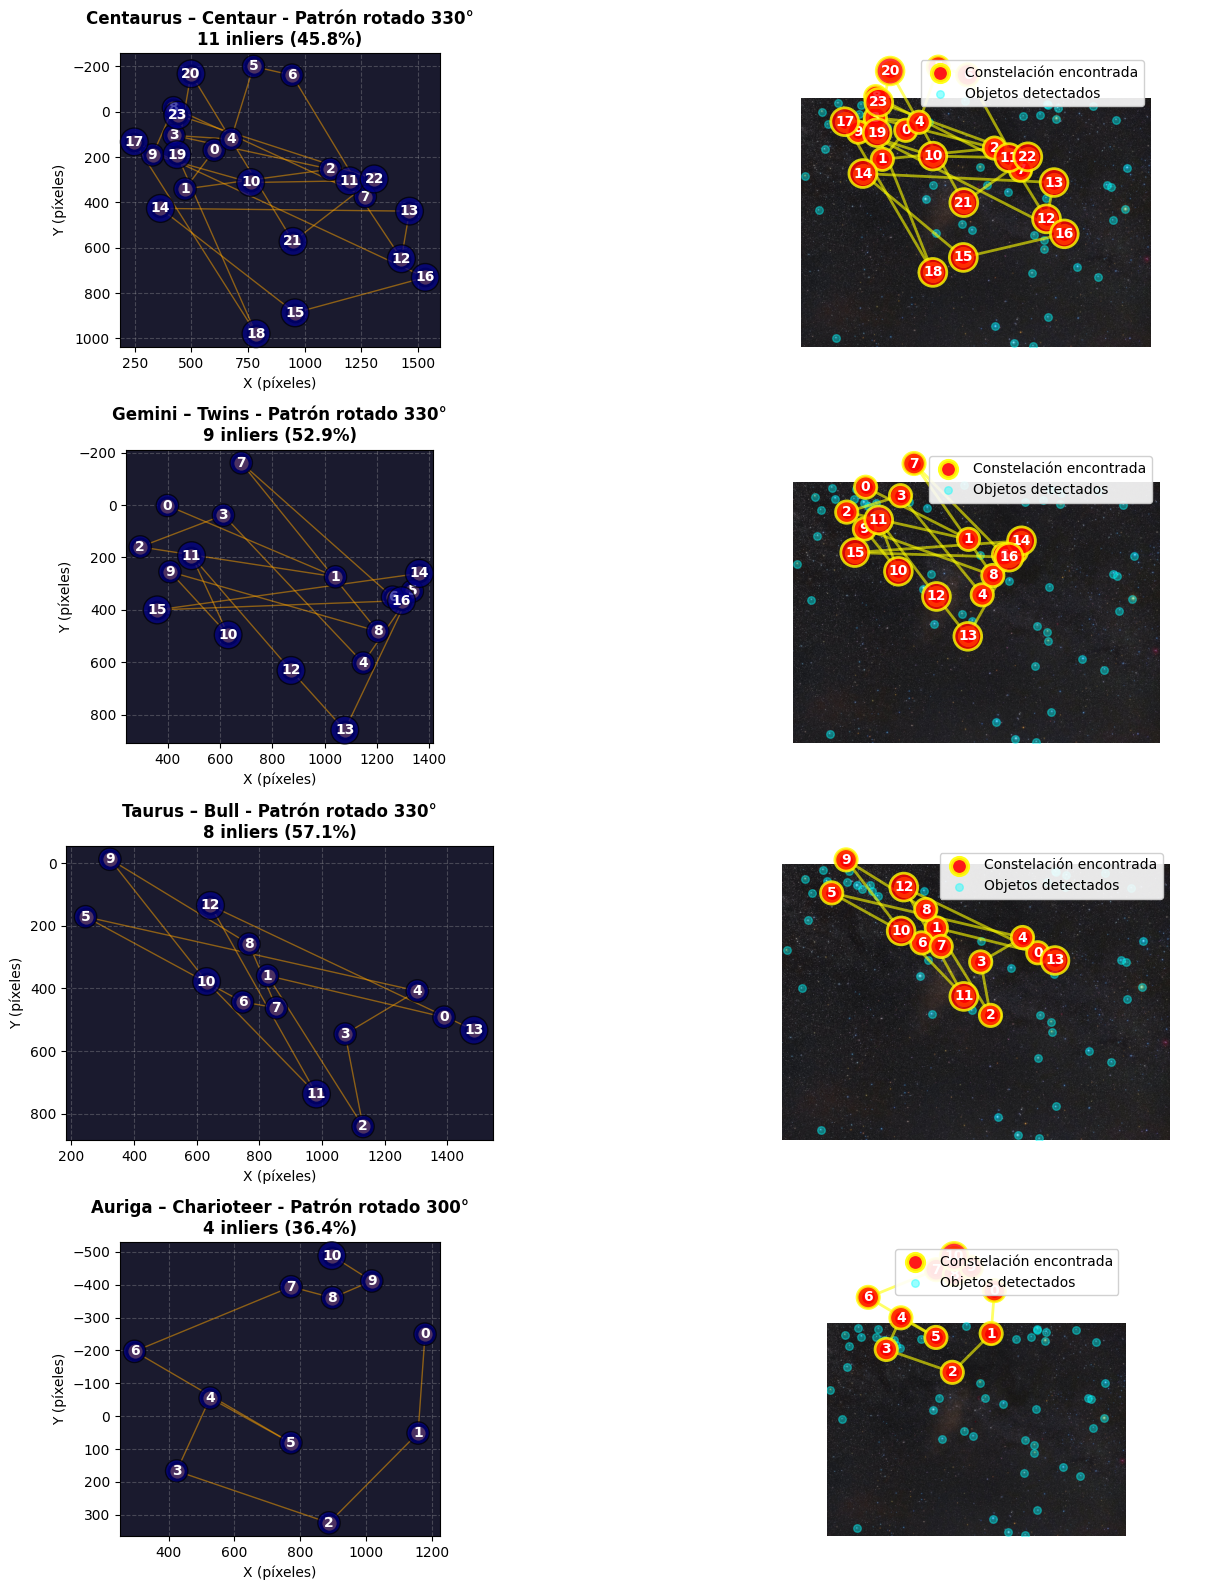


DETALLES DE LAS CONSTELACIONES ENCONTRADAS

1. CENTAURUS – CENTAUR
   ────────────────────────────────────────────────────────────
   Índice en dataset:        64
   Estrellas en patrón:      24
   Inliers encontrados:      11
   Ratio de coincidencia:    45.8%
   Ángulo de rotación:       330°
   Matriz de transformación:
   [[ 0.99540422 -0.03599954  6.23133648]
 [ 0.03599954  0.99540422 -9.29357566]]

2. GEMINI – TWINS
   ────────────────────────────────────────────────────────────
   Índice en dataset:        70
   Estrellas en patrón:      17
   Inliers encontrados:      9
   Ratio de coincidencia:    52.9%
   Ángulo de rotación:       330°
   Matriz de transformación:
   [[ 0.90053639 -0.06143397 37.28838139]
 [ 0.06143397  0.90053639 -3.68304036]]

3. TAURUS – BULL
   ────────────────────────────────────────────────────────────
   Índice en dataset:        79
   Estrellas en patrón:      14
   Inliers encontrados:      8
   Ratio de coincidencia:    57.1%
   Ángulo de rotación:

In [34]:
# Filtrar los matches para las constelaciones Gemini, Tauro y Auriga
import pandas as pd

# Primero, verificar qué nombres de constelación tenemos en el DataFrame
print("Nombres de constelaciones disponibles:")
print(df['constellation_name'].unique()[:20])  # Mostrar los primeros 20

# Buscar las constelaciones específicas usando búsqueda parcial
const_names = ['Gemini', 'Taurus', 'Auriga']

# Buscar índices donde el nombre de la constelación contiene alguno de los nombres buscados
indices = []
for const_name in const_names:
    # Buscar en el DataFrame donde el nombre contenga la palabra buscada
    mask = df['constellation_name'].str.contains(const_name, case=False, na=False)
    found_indices = df[mask].index.tolist()
    indices.extend(found_indices)
    
    if found_indices:
        print(f"\n✓ Encontrado '{const_name}':")
        for idx in found_indices:
            print(f"  - Índice {idx}: {df.iloc[idx]['constellation_name']}")
    else:
        print(f"\n✗ No se encontró '{const_name}'")

# Eliminar duplicados si los hay
indices = list(set(indices))

print(f"\nÍndices totales encontrados: {indices}")

# Convertir matches a DataFrame si aún no existe
if 'matches_df' not in locals():
    matches_df = pd.DataFrame(matches)

# Buscar los matches correspondientes
selected_matches = matches_df[matches_df['constellation_index'].isin(indices)]

# Mostrar los resultados
if selected_matches.empty:
    print(f"\n❌ No se encontraron matches para las constelaciones buscadas")
    print(f"Total de matches disponibles: {len(matches_df)}")
    print("\nConstelaciones con matches:")
    for idx in matches_df['constellation_index'].unique()[:10]:
        const_name = df.iloc[idx]['constellation_name'] if idx < len(df) else f"Índice {idx}"
        print(f"  - {const_name} (índice {idx})")
else:
    print(f"\n✓ Encontrados {len(selected_matches)} matches para las constelaciones buscadas\n")
    display(selected_matches)
    
    # Visualizar solo estos matches
    n_matches = len(selected_matches)
    fig, axes = plt.subplots(n_matches, 2, figsize=(16, 4*n_matches))
    
    # Si solo hay un match, axes no será un array 2D
    if n_matches == 1:
        axes = axes.reshape(1, -1)
    
    for idx, (match_idx, row) in enumerate(selected_matches.iterrows()):
        # Obtener datos del match
        const_idx = row['constellation_index']
        const_name = df.iloc[const_idx]['constellation_name']
        pattern_centroids = np.array(constellation_centroids[const_idx], dtype=np.float32)
        matrix = row['transformation_matrix']
        angle = row['rotation_angle']
        
        # Rotar el patrón con el ángulo encontrado
        theta = np.radians(angle)
        rot_mat = np.array([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
        rotated_pattern = np.dot(pattern_centroids, rot_mat.T)
        
        # Panel izquierdo: Patrón rotado (sin transformación afín)
        axes[idx, 0].scatter(rotated_pattern[:, 0], rotated_pattern[:, 1], 
                            c='orange', s=150, edgecolors='black', linewidths=2, zorder=3)
        
        # Conectar puntos para ver la forma de la constelación
        if len(rotated_pattern) > 1:
            for i in range(len(rotated_pattern)-1):
                axes[idx, 0].plot([rotated_pattern[i, 0], rotated_pattern[i+1, 0]],
                                 [rotated_pattern[i, 1], rotated_pattern[i+1, 1]],
                                 'orange', linewidth=1, alpha=0.5)
        
        # Numerar puntos
        for i in range(len(rotated_pattern)):
            axes[idx, 0].text(rotated_pattern[i, 0], rotated_pattern[i, 1], str(i), 
                             fontsize=10, ha='center', va='center', 
                             color='white', fontweight='bold',
                             bbox=dict(boxstyle='circle', facecolor='darkblue', alpha=0.7))
        
        axes[idx, 0].set_title(f'{const_name} - Patrón rotado {angle}°\n{row["inliers_count"]} inliers ({row["inliers_ratio"]:.1%})', 
                               fontsize=12, fontweight='bold')
        axes[idx, 0].set_aspect('equal')
        axes[idx, 0].invert_yaxis()
        axes[idx, 0].grid(True, alpha=0.3, linestyle='--')
        axes[idx, 0].set_xlabel('X (píxeles)', fontsize=10)
        axes[idx, 0].set_ylabel('Y (píxeles)', fontsize=10)
        axes[idx, 0].set_facecolor('#1a1a2e')
        
        # Panel derecho: Transformación completa sobre la imagen
        ones = np.ones((len(rotated_pattern), 1))
        rotated_homogeneous = np.hstack([rotated_pattern, ones])
        transformed = rotated_homogeneous @ matrix.T
        
        axes[idx, 1].imshow(image_np)
        
        # Dibujar líneas conectando las estrellas de la constelación
        if len(transformed) > 1:
            for i in range(len(transformed)-1):
                axes[idx, 1].plot([transformed[i, 0], transformed[i+1, 0]],
                                 [transformed[i, 1], transformed[i+1, 1]],
                                 'yellow', linewidth=2, alpha=0.6, zorder=2)
        
        # Puntos de la constelación transformada
        axes[idx, 1].scatter(transformed[:, 0], transformed[:, 1], 
                            c='red', s=150, edgecolors='yellow', linewidths=3, 
                            alpha=0.9, label='Constelación encontrada', zorder=3)
        
        # Galaxias detectadas
        axes[idx, 1].scatter(space_centroids[:, 0], space_centroids[:, 1], 
                            c='cyan', s=30, alpha=0.4, label='Objetos detectados', zorder=1)
        
        # Numerar puntos transformados
        for i in range(len(transformed)):
            axes[idx, 1].text(transformed[i, 0], transformed[i, 1], str(i), 
                             color='white', fontsize=10, ha='center', va='center',
                             fontweight='bold',
                             bbox=dict(boxstyle='circle', facecolor='red', 
                                     edgecolor='yellow', linewidth=2, alpha=0.8))
        
        axes[idx, 1].set_title(f'{const_name} - Superposición en imagen', 
                              fontsize=12, fontweight='bold', color='white')
        axes[idx, 1].legend(loc='upper right', fontsize=10, framealpha=0.9)
        axes[idx, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Mostrar información detallada
    print("\n" + "="*80)
    print("DETALLES DE LAS CONSTELACIONES ENCONTRADAS")
    print("="*80)
    for idx, (match_idx, row) in enumerate(selected_matches.iterrows(), 1):
        const_idx = row['constellation_index']
        const_name = df.iloc[const_idx]['constellation_name']
        print(f"\n{idx}. {const_name.upper()}")
        print(f"   {'─'*60}")
        print(f"   Índice en dataset:        {const_idx}")
        print(f"   Estrellas en patrón:      {len(constellation_centroids[const_idx])}")
        print(f"   Inliers encontrados:      {row['inliers_count']}")
        print(f"   Ratio de coincidencia:    {row['inliers_ratio']:.1%}")
        print(f"   Ángulo de rotación:       {row['rotation_angle']}°")
        print(f"   Matriz de transformación:")
        print(f"   {row['transformation_matrix']}")